In [1]:
%load_ext autoreload
%autoreload 2

In [105]:
import yt
import yt.units as u
import sys
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib import cm
from data_binning import *
plt.rcParams.update({
    "text.usetex": True})

In [3]:
G = u.gravitational_constant
q0 = 1e6
beta = 1
M = q0 * u.Msun
rT = q0**(1 / 3) * u.Rsun
deltaE = (G * M / rT**2 * u.Rsun).in_cgs()

In [142]:
class TDE:
    G = u.gravitational_constant
    q0 = 1e6
    beta = 1
    M = q0 * u.Msun
    rT = q0**(1 / 3) * u.Rsun
    deltaE = (G * M / rT**2 * u.Rsun).in_cgs()
    age0 = '0.445'
    ms0 = '1.0'

    def __init__(self,
                 q=q0,
                 Ecc=1,
                 beta=1,
                 file='1.000.dat',
                 ms=ms0,
                 age=age0):
        DIR = '../../STARS_library/retrieval/m{}_t{}/'.format(ms, age)
        dmdt_t0 = np.loadtxt(DIR + file)
        t0 = dmdt_t0[:, 0]
        dmdt0 = dmdt_t0[:, 1]
        dedt0 = (2 / 3 * (G**2 * M**2 * np.pi**2 / 2)**(1 / 3) *
                 (t0 * u.day)**(-5 / 3)).in_cgs()
        dmde0 = (dmdt0 * (u.Msun / u.yr) / dedt0).in_cgs()
        E = -((G**2 * M**2 * np.pi**2 / 2)**(1 / 3) *
              (t0 * u.day)**(-2 / 3)).in_cgs()
        E_dE = E / deltaE
        dmde_dE = dmde0 * deltaE
        self.M = q * u.Msun
        self.Ecc = Ecc
        self.beta = beta
        self.rT = q**(1 / 3) * u.Rsun
        self.deltaE = (G * self.M / self.rT**2 * u.Rsun).in_cgs()

        self.E = self.E_Ecc(E_dE * self.deltaE)
        self.E_most_bound = self.E_Ecc(-self.deltaE * self.beta**2)
        self.T = ((-self.E**3 * 2)**(-1 / 2) * np.pi * G *
                  self.M).in_units('day')
        self.Tfallback = self.T[0]

        self.dmde = dmde_dE / self.deltaE
        dedt = 2 / 3 * ((G**2 * self.M**2 * np.pi**2 / 2)**(1 / 3) *
                        self.T**(-5 / 3)).in_cgs()
        self.dmdt = (dedt * self.dmde).in_units('Msun/yr')

        self.Tpeak = self.T[np.argmax(self.dmdt)].in_units('day')
        self.Tpeak0 = self.Tpeak - self.Tfallback

        self.Tscale = (self.T - self.Tpeak) / (self.Tpeak - self.T[0])
        self.dmdtscale = self.dmdt / self.dmdt.max()
        self.Tscale *= 1 - self.dmdtscale[0]

        if self.Eorb == 0:
            self.Period = np.inf
        else:
            self.Period = 2 * np.pi * G * self.M / (-2 * self.Eorb)**(3 / 2)
            self.Period = self.Period.in_units('day')

    def E_Ecc(self, E):
        if self.Ecc == 1:
            self.Eorb = 0
        else:
            a = self.rT / self.beta / (1 - self.Ecc)
            self.Eorb = -G * self.M / 2 / a
        return E + self.Eorb

## Tpeak v.s. other parameters

Text(0, 0.5, '$T_\\mathrm{peak}\\ \\mathrm{[day]}$')

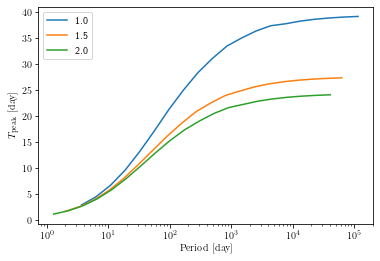

In [6]:
Ecc_range = 1 - np.logspace(-1, -4, 20)
for f in files:
    tpeak = []
    P = []
    for Ecc in Ecc_range:
        tde = TDE(Ecc=Ecc, file=f, beta=float(f[:3]), q=1e6)
        dmdt_Ecc = tde.dmdt
        P = np.append(P, tde.Period)
        tpeak = np.append(tpeak, tde.Tpeak)
    plt.plot(P, tpeak, label=f[:3])
plt.legend()
#plt.yscale('log')
plt.xscale('log')
plt.xlabel('$\mathrm{Period\ [day]}$')
plt.ylabel('$T_\mathrm{peak}\ \mathrm{[day]}$')

Text(0, 0.5, '$T_\\mathrm{peak}\\ \\mathrm{[day]}$')

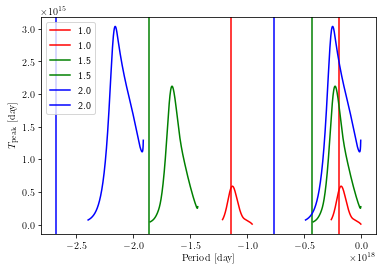

In [7]:
Ecc_range = 1 - np.logspace(-1, -4, 2)
color = ['r', 'g', 'b']
for k, f in enumerate(files):
    tpeak = []
    P = []
    for Ecc in Ecc_range:
        tde = TDE(Ecc=Ecc, file=f, beta=float(f[:3]), q=1e6)
        dmdt_Ecc = tde.dmdt
        plt.plot(tde.E, tde.dmde, label=f[:3], color=color[k])
        plt.axvline(tde.E_most_bound, color=color[k])
plt.legend()
#plt.yscale('log')
#plt.xscale('log')
plt.xlabel('$\mathrm{Period\ [day]}$')
plt.ylabel('$T_\mathrm{peak}\ \mathrm{[day]}$')

Text(0, 0.5, '$T_\\mathrm{peak}\\ \\mathrm{[day]}$')

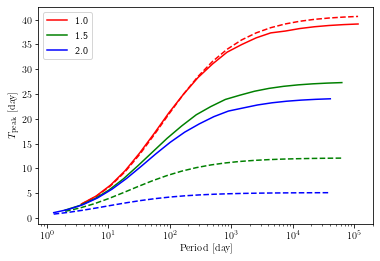

In [8]:
Ecc_range = 1 - np.logspace(-1, -4, 20)
color = ['r', 'g', 'b']
for k, f in enumerate(files):
    tf, tfa = [], []
    P = []
    for Ecc in Ecc_range:
        tde = TDE(Ecc=Ecc, file=f, beta=float(f[:3]), q=1e6)
        dmdt_Ecc = tde.dmdt
        P = np.append(P, tde.Period)
        tf = np.append(tf, tde.Tpeak)
        tfa = np.append(tfa, tde.Tfallback_analyt)
    plt.plot(P, tf, label=f[:3], color=color[k])
    plt.plot(P, tfa, color=color[k], linestyle='--')
plt.legend()
#plt.yscale('log')
plt.xscale('log')
plt.xlabel('$\mathrm{Period\ [day]}$')
plt.ylabel('$T_\mathrm{peak}\ \mathrm{[day]}$')

In [9]:
e_cri_1 = 0.9825
e_cri_5 = .93166

In [10]:
def P2Ecc(P, M=1 * u.Msun, R=1 * u.Rsun, beta=1):
    return 1 - (4 * np.pi**2 / P**2 / G / M)**(1 / 3) * R / beta

Text(0.5, 0, '$q$')

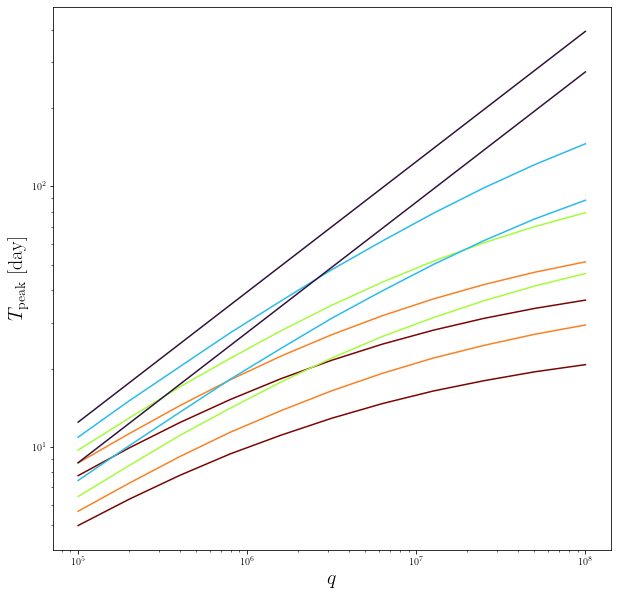

In [11]:
plt.figure(figsize=(10, 10))
q_range = np.logspace(5, 8, 11)

cmap = cm.get_cmap('turbo', 5)

for f in files[:2]:
    for level, ecc in enumerate(np.linspace(1, e_cri_1, 5)):
        #tde0 = [TDE(q=q, file=f, beta=float(f[:3])) for q in q_range]
        #plt.loglog(q_range, [tde.Tpeak for tde in tde0])
        tde_temp = [TDE(q=q, Ecc=ecc, file=f, beta=float(f[:3])) for q in q_range]
        plt.loglog(q_range, [tde.Tpeak for tde in tde_temp], color=cmap(level))
        Tpeak_ratio_analyt_temp = (((1 - ecc) / 2 + q_range**(-1 / 3)) /
                                   ((1 - ecc) / 2 + q_range[0]**(-1 / 3)))**(-3 /
                                                                             2)
        '''plt.loglog(q_range,
                   tde_temp[0].Tpeak * Tpeak_ratio_analyt_temp,
                   color=cmap(level),
                   linestyle=':')'''
        
plt.ylabel('$T_\mathrm{peak}\ \mathrm{[day]}$', fontsize=20)
plt.xlabel('$q$', fontsize=20)

Text(0.5, 0, '$q$')

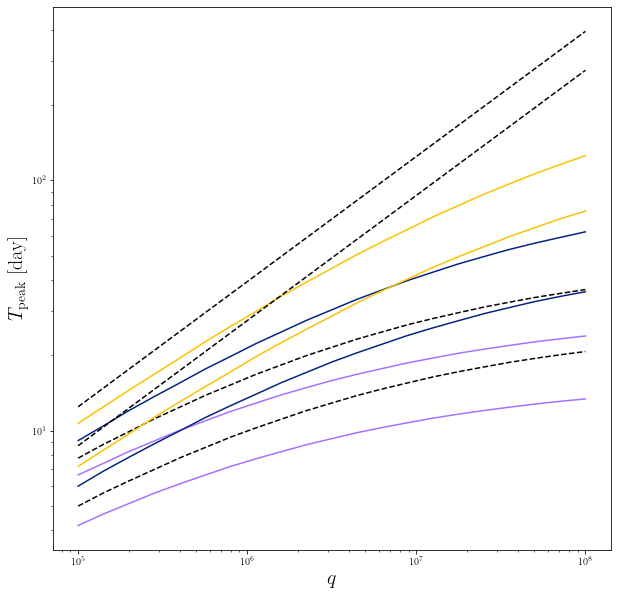

In [12]:
plt.figure(figsize=(10, 10))
q_range = np.logspace(5, 8, 21)

Ecc = P2Ecc(P=np.array([30, 100, 300])*u.day)

cmap = cm.get_cmap('Haze', 3)

for f in files[:2]:
    tde0 = [TDE(q=q, file=f, beta=float(f[:3])) for q in q_range]
    plt.loglog(q_range, [tde.Tpeak for tde in tde0], color='k', linestyle='--')
    tde_cri = [TDE(q=q, Ecc=e_cri_1, file=f, beta=float(f[:3])) for q in q_range]
    plt.loglog(q_range, [tde.Tpeak for tde in tde_cri], color='k', linestyle='--')
    for level, ecc in enumerate(Ecc):
        tde_temp = [TDE(q=q, Ecc=ecc, file=f, beta=float(f[:3])) for q in q_range]
        plt.loglog(q_range, [tde.Tpeak for tde in tde_temp], color=cmap(level))
        Tpeak_ratio_analyt_temp = (((1 - ecc) / 2 + q_range**(-1 / 3)) /
                                   ((1 - ecc) / 2 + q_range[0]**(-1 / 3)))**(-3 /
                                                                             2)
        '''plt.loglog(q_range,
                   tde_temp[0].Tpeak * Tpeak_ratio_analyt_temp,
                   color=cmap(level),
                   linestyle=':')'''
plt.ylabel('$T_\mathrm{peak}\ \mathrm{[day]}$', fontsize=20)
plt.xlabel('$q$', fontsize=20)

In [13]:
from astropy.table import Table

16


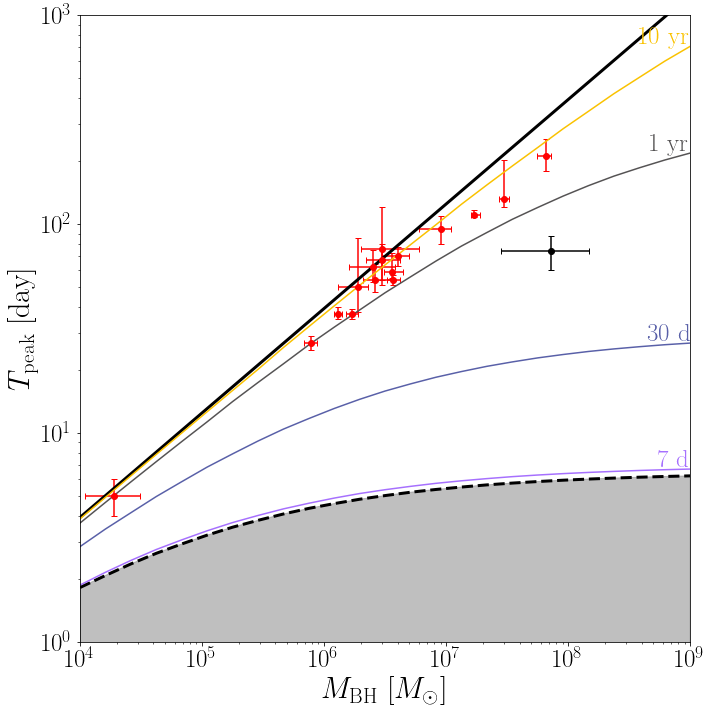

In [14]:
#ASASSN14ko
ASMh = 10**7.86
ASMheup = 10**(7.86 + 0.31) - ASMh
ASMhelo = ASMh - 10**(7.86 - 0.41)

ASMh_fit = 10**7.81
ASMheup_fit = 10**(7.81 + 0.17) - ASMh
ASMhelo_fit = ASMh - 10**(7.81 - 0.29)

AStp = 74
AStpeup = 14
AStpelo = 14

AStp2 = 44
AStpeup2 = 3
AStpelo2 = 3

M_tpeak = Table.read('M_tpeak.csv', comment='#')
print(len(M_tpeak))
Mherr = np.array([-M_tpeak['Mhe-'], M_tpeak['Mhe+']]) * 1e6
tperr = np.array([-M_tpeak['tpe-'], M_tpeak['tpe+']])

plt.figure(figsize=(10, 10))

plt.errorbar(M_tpeak['Mh'] * 1e6,
             M_tpeak['tp'],
             xerr=Mherr,
             yerr=tperr,
             fmt='o',
             capsize=3,
             color='r')

plt.errorbar(ASMh,
             AStp,
             xerr=[[ASMhelo], [ASMheup]],
             yerr=[[AStpelo], [AStpeup]],
             fmt='o',
             capsize=3,
             color='k')

q_range = np.logspace(4, 9, 25)
tde0 = [TDE(q=q, file='1.000.dat') for q in q_range]
plt.loglog(q_range, [tde.Tpeak for tde in tde0], color='k', linewidth=3)
tde_cri = [TDE(q=q, Ecc=e_cri_5, file='1.000.dat') for q in q_range]
plt.loglog(q_range, [tde.Tpeak for tde in tde_cri],
           color='k',
           linestyle='--',
           linewidth=3)
plt.fill_between(q_range, [tde.Tpeak for tde in tde_cri], color='grey', alpha=0.5)

P_range = np.array([7, 30, 365.25, 3652.5]) * u.day
Ecc = P2Ecc(P_range)

cmap = cm.get_cmap('Haze', 4)

S = [None, None, '$1\ \mathrm{yr}$', '$10\ \mathrm{yr}$']

for level, ecc in enumerate(Ecc):
    tde_temp = [TDE(q=q, Ecc=ecc, file='1.000.dat') for q in q_range]
    plt.loglog(q_range, [tde.Tpeak for tde in tde_temp], color=cmap(level))
    if S[level] == None:
        s = '${:.0f}$'.format(P_range[level].v) + '$\ \mathrm{d}$'
    else:
        s = S[level]
    plt.text(x=q_range[-1],
             y=tde_temp[-1].Tpeak * 1.03,
             s=s,
             fontsize=25,
             ha='right',
             color=cmap(level))
    '''Tpeak_ratio_analyt_temp = (((1 - ecc) / 2 + q_range**(-1 / 3)) /
                               ((1 - ecc) / 2 + q_range[0]**(-1 / 3)))**(-3 /
                                                                         2)
    plt.loglog(q_range,
               tde_temp[0].Tpeak * Tpeak_ratio_analyt_temp,
               color=cmap(level),
               linestyle=':')'''
plt.xlim(1e4, 1e9)
plt.ylim(1e0, 1e3)
plt.ylabel('$T_\mathrm{peak}\ \mathrm{[day]}$', fontsize=30)
plt.xlabel('$M_\mathrm{BH}\ [M_\odot]$', fontsize=30)
plt.gca().tick_params(labelsize=25)
plt.tight_layout()
plt.savefig('Tp_q.pdf', bbox_inches='tight')

## Mdot v.s. t

In [15]:
#P = 114 day, beta = 1, Ecc?
Ecc114 = 1 - ((2 * np.pi / 114 / u.day)**2 / G / u.Msun)**(1 / 3) * u.Rsun
Ecc114

unyt_quantity(0.98989573, '(dimensionless)')

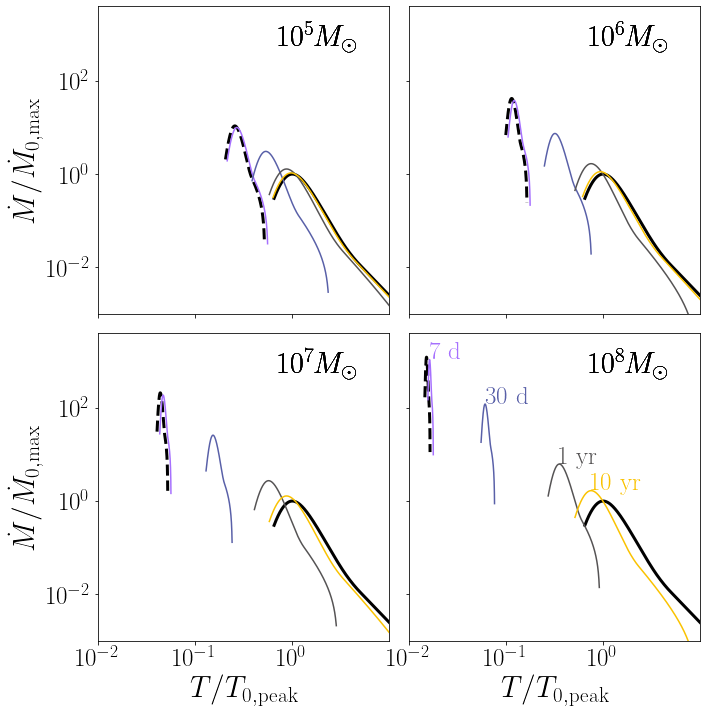

In [207]:
f, ax = plt.subplots(2, 2, figsize=(10, 10), sharex=True, sharey=True)
ax = ax.flatten()
Q = [1e5, 1e6, 1e7, 1e8]

k = 0
for a, q in zip(ax, Q):
    tde0 = TDE(Ecc=1, beta=1.0, file='1.000.dat', q=q)
    Tpeak0 = tde0.Tpeak
    dmdt0 = tde0.dmdt.max()
    a.loglog(tde0.T / Tpeak0, tde0.dmdt / dmdt0, color='k', linewidth=3)

    tde_cri = TDE(Ecc=e_cri_5, beta=1.0, file='1.000.dat', q=q)
    a.loglog(tde_cri.T / Tpeak0,
             tde_cri.dmdt / dmdt0,
             color='k',
             linestyle='--',
             linewidth=3)

    P_range = np.array([7, 30, 365.25, 3652.5]) * u.day
    Ecc = P2Ecc(P_range)
    cmap = cm.get_cmap('Haze', 4)

    for level, ecc in enumerate(Ecc):
        tde = TDE(Ecc=ecc, beta=1.0, file='1.000.dat', q=q)
        a.loglog(tde.T / Tpeak0, tde.dmdt / dmdt0, color=cmap(level))
        if S[level] == None:
            s = '${:.0f}$'.format(P_range[level].v) + '$\ \mathrm{d}$'
        else:
            s = S[level]
        a.text(x=0.9,
               y=0.9,
               s=r'$10^{:.0f}M_\odot$'.format(np.log10(q)),
               fontsize=30,
               ha='right',
               va='center',
               transform=a.transAxes)
        if k == 3:
            a.text(x=tde.T[np.argmax(tde.dmdt)] / Tpeak0,
                   y=tde.dmdt.max() / dmdt0 * 1.05,
                   s=s,
                   fontsize=25,
                   color=cmap(level))

    a.tick_params(labelsize=25)
    k += 1

ax[0].set_ylabel('$\dot M/\dot M_\mathrm{0, max}$', fontsize=30)
ax[2].set_ylabel('$\dot M/\dot M_\mathrm{0, max}$', fontsize=30)
ax[2].set_xlabel('$T/T_\mathrm{0, peak}$', fontsize=30)
ax[3].set_xlabel('$T/T_\mathrm{0, peak}$', fontsize=30)
plt.tight_layout()
plt.xlim(1e-2, 1e1)
plt.ylim(1e-3, 4e3)
plt.xticks([1e-2, 1e-1, 1e0])
plt.yticks([1e-2, 1e0, 1e2])
plt.ylim(1e-3, 4e3)
plt.savefig('Mdot_T.pdf', bbox_inches='tight')

(0.0001, 100.0)

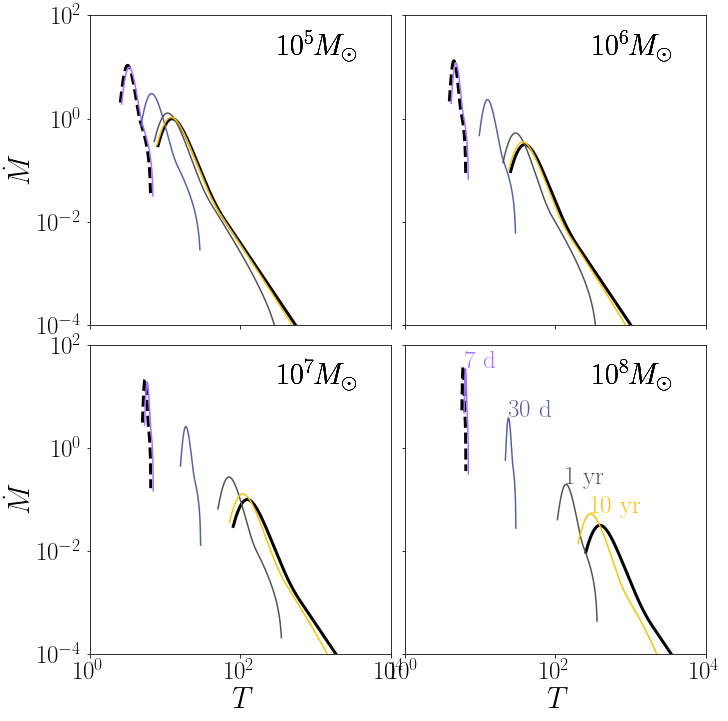

In [211]:
f, ax = plt.subplots(2, 2, figsize=(10, 10), sharex=True, sharey=True)
ax = ax.flatten()
Q = [1e5, 1e6, 1e7, 1e8]

k = 0
for a, q in zip(ax, Q):
    tde0 = TDE(Ecc=1, beta=1.0, file='1.000.dat', q=q)
    Tpeak0 = tde0.Tpeak
    dmdt0 = tde0.dmdt.max()
    a.loglog(tde0.T, tde0.dmdt, color='k', linewidth=3)

    tde_cri = TDE(Ecc=e_cri_5, beta=1.0, file='1.000.dat', q=q)
    a.loglog(tde_cri.T, tde_cri.dmdt, color='k', linestyle='--', linewidth=3)

    P_range = np.array([7, 30, 365.25, 3652.5]) * u.day
    Ecc = P2Ecc(P_range)
    cmap = cm.get_cmap('Haze', 4)

    for level, ecc in enumerate(Ecc):
        tde = TDE(Ecc=ecc, beta=1.0, file='1.000.dat', q=q)
        a.loglog(tde.T, tde.dmdt, color=cmap(level))
        if S[level] == None:
            s = '${:.0f}$'.format(P_range[level].v) + '$\ \mathrm{d}$'
        else:
            s = S[level]
        a.text(x=0.9,
               y=0.9,
               s=r'$10^{:.0f}M_\odot$'.format(np.log10(q)),
               fontsize=30,
               ha='right',
               va='center',
               transform=a.transAxes)
        if k == 3:
            a.text(x=tde.T[np.argmax(tde.dmdt)],
                   y=tde.dmdt.max() * 1.05,
                   s=s,
                   fontsize=25,
                   color=cmap(level))

    a.tick_params(labelsize=25)
    k += 1

ax[0].set_ylabel('$\dot M$', fontsize=30)
ax[2].set_ylabel('$\dot M$', fontsize=30)
ax[2].set_xlabel('$T$', fontsize=30)
ax[3].set_xlabel('$T$', fontsize=30)
plt.tight_layout()
plt.xlim(1e0, 1e4)
plt.ylim(1e-4, 1e2)
#plt.xticks([1e-2, 1e-1, 1e0])
#plt.yticks([1e-2, 1e0, 1e2])
#plt.savefig('Mdot_T.pdf', bbox_inches='tight')

(0.0, 1.0)

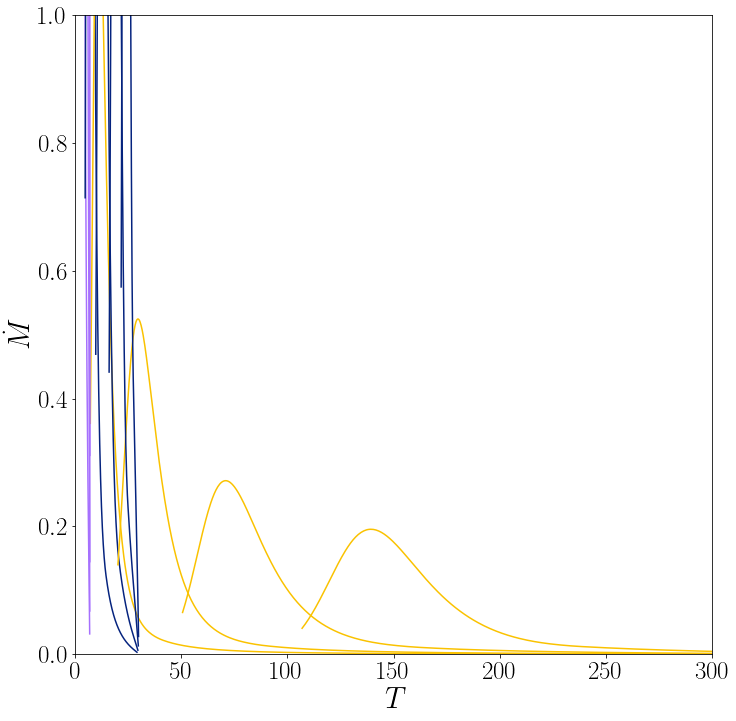

In [229]:
f, ax = plt.subplots(1, 1, figsize=(10, 10), sharex=True, sharey=True)
a = ax
Q = [1e5, 1e6, 1e7, 1e8]

k = 0
for q in Q:

    P_range = np.array([7, 30, 365.25]) * u.day
    Ecc = P2Ecc(P_range)
    cmap = cm.get_cmap('Haze', 3)

    for level, ecc in enumerate(Ecc):
        tde = TDE(Ecc=ecc, beta=1.0, file='1.000.dat', q=q)
        a.plot(tde.T, tde.dmdt, color=cmap(level))
        if S[level] == None:
            s = '${:.0f}$'.format(P_range[level].v) + '$\ \mathrm{d}$'
        else:
            s = S[level]

    a.tick_params(labelsize=25)
    k += 1

ax.set_ylabel('$\dot M$', fontsize=30)
ax.set_xlabel('$T$', fontsize=30)
plt.tight_layout()
plt.xlim(0, 300)
plt.ylim(0, 1)
#plt.xticks([1e-2, 1e-1, 1e0])
#plt.yticks([1e-2, 1e0, 1e2])
#plt.savefig('Mdot_T.pdf', bbox_inches='tight')

In [134]:
TESS = np.loadtxt('../mosfit_bin/TESS_cgs_sector3-5.dat')
TESS = TESS[TESS[:, 0] > 2458429]
TESS = TESS[TESS[:, 1] > 0]

TESS = data_binning(TESS, 1)

tpeak = TESS[np.argmax(TESS[:, 1]), 0]
TESS_tscale = (TESS[:, 0] - tpeak) / (tpeak - TESS[0, 0])
TESS_dmdtscale = TESS[:, 1] / TESS[:, 1].max()
TESS_dmdterrscale = TESS[:, 2] / TESS[:, 1].max()

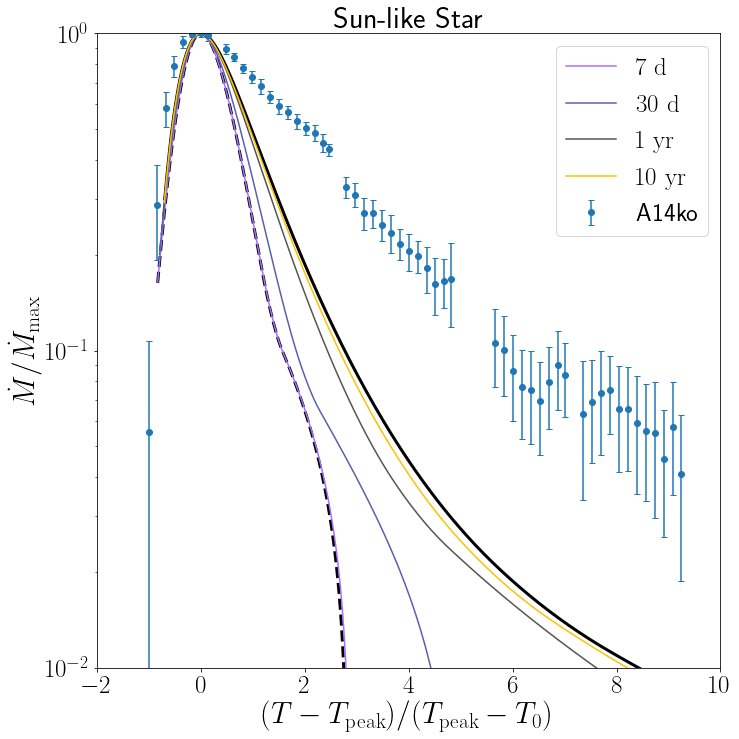

In [139]:
plt.figure(figsize=(10, 10))

tde0 = TDE(Ecc=1, beta=1.0, file='1.000.dat')
Tpeak0 = tde0.Tpeak
dmdt0 = tde0.dmdt.max()
plt.plot(tde0.Tscale, tde0.dmdtscale, color='k', linewidth=3)

tde_cri = TDE(Ecc=e_cri_5, beta=1.0, file='1.000.dat')
plt.plot(tde_cri.Tscale,
         tde_cri.dmdtscale,
         color='k',
         linestyle='--',
         linewidth=3)

P_range = np.array([7, 30, 365.25, 3652.5]) * u.day
Ecc = P2Ecc(P_range)
cmap = cm.get_cmap('Haze', 4)

plt.errorbar(TESS_tscale,
             TESS_dmdtscale,
             yerr=TESS_dmdterrscale,
             fmt='o',
             capsize=3,
             label='A14ko')

for level, ecc in enumerate(Ecc):
    tde = TDE(Ecc=ecc, beta=1.0, file='1.000.dat')
    if S[level] == None:
        s = '${:.0f}$'.format(P_range[level].v) + '$\ \mathrm{d}$'
    else:
        s = S[level]
    plt.plot(tde.Tscale, tde.dmdtscale, color=cmap(level), label=s)
    '''plt.text(x=tde.T[np.argmax(tde.dmdt)] / Tpeak0,
             y=tde.dmdt.max() / dmdt0 * 1.05,
             s=s,
             fontsize=25,
             color=cmap(level))'''

plt.ylabel('$\dot M/\dot M_\mathrm{max}$', fontsize=30)
plt.xlabel('$(T-T_\mathrm{peak})/(T_\mathrm{peak}-T_0)$', fontsize=30)
plt.gca().tick_params(labelsize=25)
plt.tight_layout()
plt.xlim(-2, 10)
plt.ylim(1e-2, 1e0)
plt.legend(prop={'size': 25})
#plt.xscale('log')
plt.yscale('log')
plt.title('Sun-like Star', fontsize=30)
plt.savefig('/Users/chang/Desktop/Mdot_T_sun.pdf', bbox_inches='tight')

Text(0.5, 1.0, 'ZAMS')

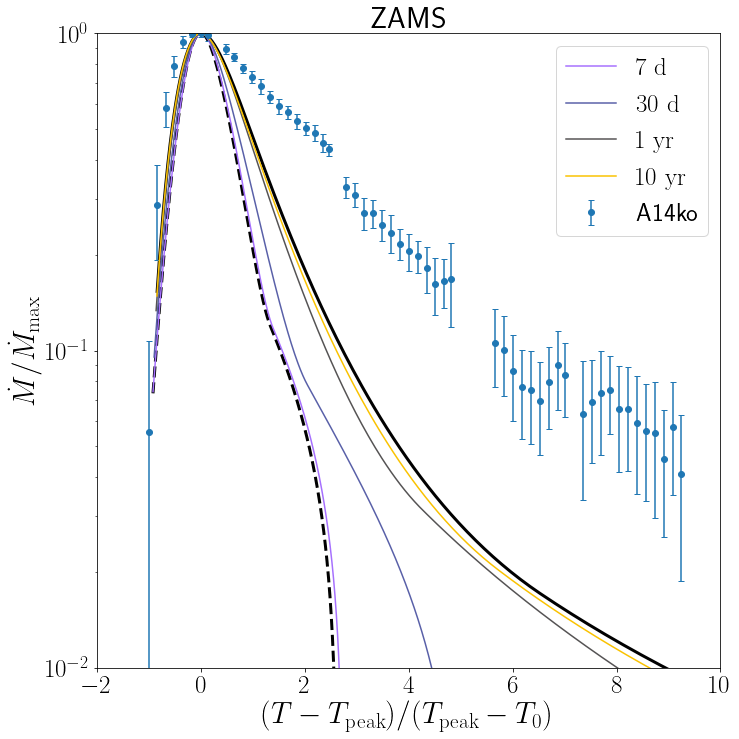

In [160]:
plt.figure(figsize=(10, 10))

tde0 = TDE(Ecc=1, beta=1.0, file='1.000.dat', age='0.0')
Tpeak0 = tde0.Tpeak
dmdt0 = tde0.dmdt.max()
plt.plot(tde0.Tscale, tde0.dmdtscale, color='k', linewidth=3)

tde_cri = TDE(Ecc=e_cri_5, beta=1.0, file='1.000.dat', age='0.0')
plt.plot(tde_cri.Tscale,
         tde_cri.dmdtscale,
         color='k',
         linestyle='--',
         linewidth=3)

P_range = np.array([7, 30, 365.25, 3652.5]) * u.day
Ecc = P2Ecc(P_range)
cmap = cm.get_cmap('Haze', 4)

plt.errorbar(TESS_tscale,
             TESS_dmdtscale,
             yerr=TESS_dmdterrscale,
             fmt='o',
             capsize=3,
             label='A14ko')

for level, ecc in enumerate(Ecc):
    tde = TDE(Ecc=ecc, beta=1.0, file='1.000.dat', age='0.0')
    if S[level] == None:
        s = '${:.0f}$'.format(P_range[level].v) + '$\ \mathrm{d}$'
    else:
        s = S[level]
    plt.plot(tde.Tscale, tde.dmdtscale, color=cmap(level), label=s)
    '''plt.text(x=tde.T[np.argmax(tde.dmdt)] / Tpeak0,
             y=tde.dmdt.max() / dmdt0 * 1.05,
             s=s,
             fontsize=25,
             color=cmap(level))'''

plt.ylabel('$\dot M/\dot M_\mathrm{max}$', fontsize=30)
plt.xlabel('$(T-T_\mathrm{peak})/(T_\mathrm{peak}-T_0)$', fontsize=30)
plt.gca().tick_params(labelsize=25)
plt.tight_layout()
plt.xlim(-2, 10)
plt.ylim(1e-2, 1e0)
#plt.xscale('log')
plt.legend(prop={'size': 25})
plt.yscale('log')
plt.title('ZAMS', fontsize=30)
#plt.savefig('/Users/chang/Desktop/Mdot_T_zams.pdf', bbox_inches='tight')

Text(0.5, 1.0, 'ZAMS')

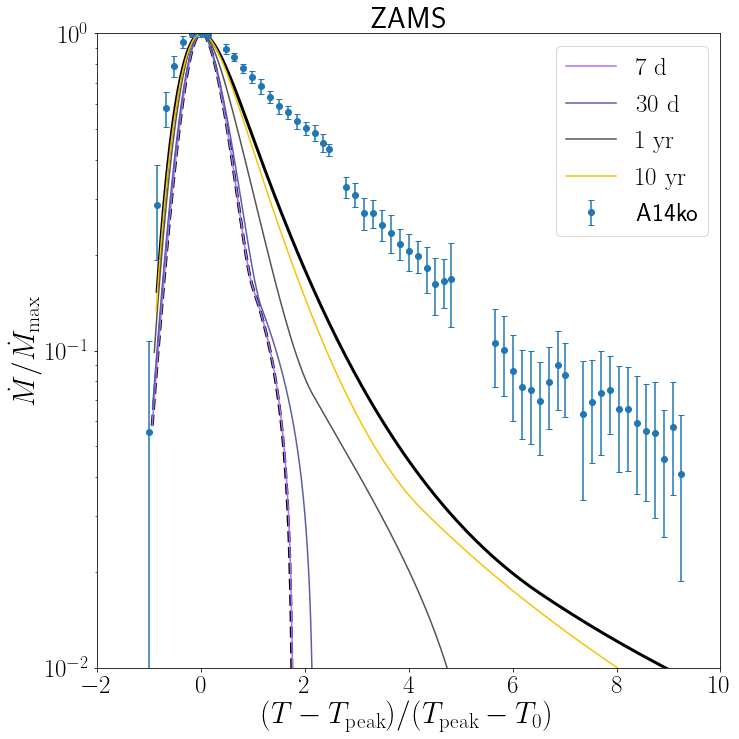

In [168]:
plt.figure(figsize=(10, 10))

tde0 = TDE(Ecc=1, beta=1.0, file='1.000.dat', age='0.0', q=1e8)
Tpeak0 = tde0.Tpeak
dmdt0 = tde0.dmdt.max()
plt.plot(tde0.Tscale, tde0.dmdtscale, color='k', linewidth=3)

tde_cri = TDE(Ecc=e_cri_5, beta=1.0, file='1.000.dat', age='0.0', q=1e8)
plt.plot(tde_cri.Tscale,
         tde_cri.dmdtscale,
         color='k',
         linestyle='--',
         linewidth=3)

P_range = np.array([7, 30, 365.25, 3652.5]) * u.day
Ecc = P2Ecc(P_range)
cmap = cm.get_cmap('Haze', 4)

plt.errorbar(TESS_tscale,
             TESS_dmdtscale,
             yerr=TESS_dmdterrscale,
             fmt='o',
             capsize=3,
             label='A14ko')

for level, ecc in enumerate(Ecc):
    tde = TDE(Ecc=ecc, beta=1.0, file='1.000.dat', age='0.0', q=1e8)
    if S[level] == None:
        s = '${:.0f}$'.format(P_range[level].v) + '$\ \mathrm{d}$'
    else:
        s = S[level]
    plt.plot(tde.Tscale, tde.dmdtscale, color=cmap(level), label=s)
    '''plt.text(x=tde.T[np.argmax(tde.dmdt)] / Tpeak0,
             y=tde.dmdt.max() / dmdt0 * 1.05,
             s=s,
             fontsize=25,
             color=cmap(level))'''

plt.ylabel('$\dot M/\dot M_\mathrm{max}$', fontsize=30)
plt.xlabel('$(T-T_\mathrm{peak})/(T_\mathrm{peak}-T_0)$', fontsize=30)
plt.gca().tick_params(labelsize=25)
plt.tight_layout()
plt.xlim(-2, 10)
plt.ylim(1e-2, 1e0)
#plt.xscale('log')
plt.legend(prop={'size': 25})
plt.yscale('log')
plt.title('ZAMS', fontsize=30)
#plt.savefig('/Users/chang/Desktop/Mdot_T_zams.pdf', bbox_inches='tight')